In [4]:
from fastai.vision.all import *
from fastaudio.all import *
from fastai.text.all import *

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [164]:
import editdistance
from fastai.callback.wandb import *

In [5]:
path = Path('../')

In [6]:
import romkan

In [7]:
table = {k:g for (k,g) in zip(["か゚","く゚","け゚","き゚",'こ゚', 'カ゚','ク゚','ケ゚','キ゚','コ゚'], 'がぐげぎごがぐげぎご')}

In [8]:
def convert_to_voiced(kana):
    for key,value in table.items():
        kana = kana.replace(key,value)
    return kana

In [9]:
convert_to_voiced('か゚')

'が'

In [10]:
labels = pd.read_csv('../training.csv', index_col=0)

In [11]:
labels.kana = labels.kana.map(convert_to_voiced)

In [12]:
labels.kana = labels.kana.map(romkan.to_hepburn)

In [13]:
labels.kana = labels.kana.map(romkan.to_katakana)

In [14]:
labels.kana = labels.kana.map(romkan.to_hepburn)

In [15]:
words = L(labels.kana.values.tolist())

In [16]:
whole = ''.join([word for word in words])

In [17]:
whole[:100]

'aruomounadowatakushimirukuruikuyukujibundo-ho-dekirukangaerukangaeruiimotsuwakaruderuokonauyaruyakuw'

In [18]:
vocab = L('',*list(whole))

In [19]:
vocab = vocab.unique()

In [20]:
vocab

(#27) ['','a','r','u','o','m','n','d','w','t'...]

In [21]:
letter2idx = {letter:idx for (idx,letter) in enumerate(vocab)}

In [22]:
letter2idx

{'': 0,
 'a': 1,
 'r': 2,
 'u': 3,
 'o': 4,
 'm': 5,
 'n': 6,
 'd': 7,
 'w': 8,
 't': 9,
 'k': 10,
 's': 11,
 'h': 12,
 'i': 13,
 'y': 14,
 'j': 15,
 'b': 16,
 '-': 17,
 'e': 18,
 'g': 19,
 'p': 20,
 'z': 21,
 'c': 22,
 'f': 23,
 "'": 24,
 'x': 25,
 ' ': 26}

In [23]:
splits = ColSplitter()(labels)
aud2spec = AudioToSpec.from_cfg(AudioConfig.Voice(f_min=0))

In [24]:
x_tfms = [lambda x: x[0], lambda x1: path/x1, AudioTensor.create,
          Resample(16_000), RemoveSilence(), ResizeSignal(2000)]
y_tfms = [lambda y: y["kana"], lambda y1: TensorText([letter2idx[i] for i in y1])]
dsets = Datasets(labels, [x_tfms, y_tfms], splits = splits)
dsets

(#160763) [(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([1, 2, 3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([4, 5, 4, 3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([6, 1, 7, 4])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 8,  1,  9,  1, 10,  3, 11, 12, 13])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 5, 13,  2,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([10,  3,  2,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([13, 10,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([14,  3, 10,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([15, 13, 16,  3,  6])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 7,  4, 17]))...]

In [47]:
class SqueezeSpec(Transform):
    def encodes(self, x:AudioSpectrogram): return x.squeeze()#.cuda()

In [48]:
dls = dsets.dataloaders(before_batch = Pad_Chunk(0), after_batch=[aud2spec, SqueezeSpec()])
b = dls.one_batch()

In [267]:
class oldJasperSubblock(Module):
    r"A basic building sub-block of Jasper"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Conv1d(in_channels, out_channels, kernel, stride, (kernel-1)//2, **kwargs)
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
    
class JasperSubblock(Module):
    r"A basic building sub-block of Jasper with QuartzNet separable convolutions"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Sequential(nn.Conv1d(in_channels, in_channels, kernel, stride, (kernel-1)//2, groups=in_channels, **kwargs),
                                 nn.Conv1d(in_channels, out_channels, 1, 1))
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
class JasperBlock(Module):
    
    def __init__(self, in_channels, out_channels, kernel, num_subblocks=3, drop = 0.2):
        self.subblocks = nn.Sequential(*[JasperSubblock(in_channels, out_channels, kernel, 1, drop = 0.2)] \
        + [JasperSubblock(out_channels, out_channels, kernel, 1, drop = 0.2) for i in range(num_subblocks-2)])
        self.res_subblock = JasperSubblock(out_channels, out_channels, kernel, 1, drop = 0.2)
        self.res_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.res_norm = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x, res = self.subblocks(x), self.res_conv(x)
        x = self.res_subblock(x, self.res_norm(x))
        return x
    
class Jasper(Module):
    
    def __init__(self, n_mels, n_vocab, num_blocks_factor=1, num_subblocks = 3):
        KERNELS = [11, 13, 17, 21, 25]
        OUTS = [256, 384, 512, 640, 768, 256]
        DROPS = [0.2]*3 + [0.3]*2
        
        self.model = nn.Sequential(*[oldJasperSubblock(n_mels, 256, 11, 2)] \
        + [JasperBlock(OUTS[i-1], OUTS[i], KERNELS[i], num_subblocks, DROPS[i])
           for i in range(5) for _ in range(num_blocks_factor)] \
        + [oldJasperSubblock(OUTS[-2], 896, 29, 1, 0.4, dilation=2)],
          oldJasperSubblock(896, 1024, 1, 1, 0.4), nn.Conv1d(1024, n_vocab, 1), nn.Softmax(1) # LogSoftmax??
        )
        
    def forward(self, x):
        return self.model(x)

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7f620c99b4c0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [70]:
model = Jasper(b[0].shape[1], len(vocab)).cuda()

In [53]:
b[0].shape

torch.Size([64, 128, 251])

In [55]:
x,y = b

In [105]:
y.shape

torch.Size([64, 18])

In [71]:
out = model(x)
out.shape

torch.Size([64, 27, 98])

In [109]:
out_rear =  torch.einsum("ijk->kij",out).cpu()
out_l = torch.full(fill_value = out_rear.shape[0], size = (out_rear.shape[1],) ).cpu()
y_l = torch.full(fill_value = y.shape[1], size = (y.shape[0],)).cpu()

In [92]:
out_rear.shape

torch.Size([98, 64, 27])

In [103]:
y_rear.shape

torch.Size([18, 64])

In [118]:
loss = nn.CTCLoss()(Tensor(out_rear), y, out_l, y_l)
loss

TensorText(15.0219, grad_fn=<AliasBackward>)

In [119]:
loss.backward()

In [134]:
CTC = nn.CTCLoss()
def ctc_loss_no_lens(preds, targs):
    preds = Tensor(torch.einsum("ijk->kij",preds).cpu())
    preds_l = torch.full(fill_value = preds.shape[0], size = (preds.shape[1],) )#.cpu()
    targs_l = torch.full(fill_value = targs.shape[1], size = (targs.shape[0],))#.cpu()
    return CTC(preds, targs, preds_l, targs_l)

In [147]:
ctc_loss_no_lens(out, y)

TensorText(15.0219, grad_fn=<AliasBackward>)

In [154]:
out.shape

torch.Size([64, 27, 98])

In [156]:
out.argmax(1).shape

torch.Size([64, 98])

In [157]:
def CER(inp, targ):
    inp = inp.argmax(1)

In [161]:
torch.ctc_loss??

Docstring: <no docstring>
Type:      builtin_function_or_method


In [150]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/.conda/envs/default/lib/python3.9/site-packages/fastai/metrics.py
Type:      function


In [162]:
import wandb

In [163]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mizoru (use `wandb login --relogin` to force relogin)


True

In [166]:
wandb.init()

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [167]:
learn = Learner(dls, model, loss_func=ctc_loss_no_lens, cbs=[WandbCallback(), SaveModelCallback()])

SuggestedLRs(valley=0.004365158267319202)

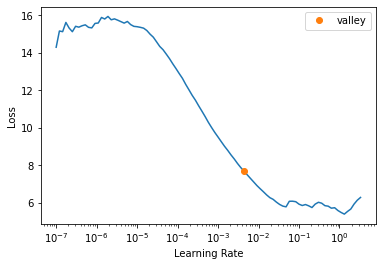

In [168]:
learn.lr_find()

In [170]:
learn.fit_one_cycle(6, 5e-3)

epoch,train_loss,valid_loss,time
0,-1.156710,-0.658196,13:41
1,-1.606376,-1.097451,13:31


WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary
Better model found at epoch 0 with valid_loss value: -0.658196210861206.
Better model found at epoch 1 with valid_loss value: -1.097451090812683.


KeyboardInterrupt: 

In [171]:
learn.save('Jasper')

Path('models/Jasper.pth')

In [179]:
pred = learn.model(x)

In [185]:
pred[0].shape

torch.Size([27, 98])

In [192]:
[''.join([vocab[i] for i in pred[j].argmax(0)]) for j in range(64)]

['koomerukaku',
 'kenjiu',
 'seinssoo',
 'kaakarakinaaa',
 'furekakeru',
 'isaai',
 'imikukasshhiiiii',
 'koouginnsssurrbbaa',
 'haakenakaattaa',
 'okomamenaii',
 'idan',
 'datkaissuuru',
 'kaahioono',
 'mijuiisshiinnai',
 'ssumagawakikanakattaaaa',
 'ankokaaa',
 'nononamasshia',
 'waakuuu',
 'saawaroou',
 'aakumakee',
 'aakukaaimaaasuu',
 'noraroree',
 'kiroo',
 'chinkaichhi',
 'torimero',
 'fumusshhiiii',
 'nausshinaattaaa',
 'kaigai',
 'yokukasshisuruuu',
 'sho-shaanne',
 'jyu-juu-',
 'shu-ryo--',
 'kerimiii',
 'manreo',
 'doo-gakuu',
 'jyo-shin',
 'jiyoouushhiite',
 'shu-rokukaaant',
 'ikarerru',
 'shikoo-keiarann',
 'doo-kassuiitoo',
 'shunroooo',
 'oouaakakanaaa',
 'kaakenakak',
 'marette',
 'seimenseai',
 'sennkuu',
 'urakatoo',
 'makeriii',
 'momoktaa',
 'fuimann',
 'shuennnshiiyyouu',
 'jyu-yoo-',
 'mikimooshhiii',
 'ooosomanaii',
 'mensaatsuu',
 'saakuru',
 'okukasshihareruuu',
 'kennman',
 'achikokasaerru',
 'kookukooo',
 'keikukuke',
 'nunamisshirroo',
 'koshiikuku']

In [206]:
def unpad(text):
    return Pad_Chunk(0).decode(text)

In [226]:
def ctc_decode(pred, empid = 0):
    pred = pred.argmax(0)
    dec = [empid]
    for i in range(len(pred)):
        cur = int(pred[i])
        if cur != dec[-1]: dec.append(cur)
    return [i for i in dec if i!=0]

In [228]:
ctc_decode(pred[0])

[10, 4, 5, 18, 2, 3, 10, 1, 10, 3]

In [234]:
def ids_to_str(ids):
    return ''.join([vocab[i] for i in ids])

In [238]:
preds,targs = learn.get_preds()

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7f620c99b4c0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [235]:
[ids_to_str(ctc_decode(pred[i])) for i in range(64)]

['komerukaku',
 'kenjiu',
 'seinso',
 'kakarakina',
 'furekakeru',
 'isai',
 'imikukashi',
 'kouginsurba',
 'hakenakatta',
 'okomamenai',
 'idan',
 'datkaisuru',
 'kahiono',
 'mijuishinai',
 'sumagawakikanakatta',
 'ankoka',
 'nononamashia',
 'waku',
 'sawarou',
 'akumake',
 'akukaimasu',
 'noraroree',
 'kiro',
 'chinkaichi',
 'torimero',
 'fumushi',
 'naushinatta',
 'kaigai',
 'yokukashisuru',
 'sho-shanne',
 'jyu-ju-',
 'shu-ryo-',
 'kerimi',
 'manreo',
 'do-gaku',
 'jyo-shin',
 'jiyoushite',
 'shu-rokukant',
 'ikareru',
 'shiko-keiaran',
 'do-kasuito',
 'shunro',
 'ouakakana',
 'kakenakak',
 'marette',
 'seimenseai',
 'senku',
 'urakato',
 'makeri',
 'momokta',
 'fuiman',
 'shuenshiyou',
 'jyu-yo-',
 'mikimoshi',
 'osomanai',
 'mensatsu',
 'sakuru',
 'okukashihareru',
 'kenman',
 'achikokasaeru',
 'kokuko',
 'keikukuke',
 'nunamishiro',
 'koshikuku']

In [251]:
print('prediction', 'target', sep='\t')
print()
for i in range(1000,1100):
    print(*[ids_to_str(i) for i in (ctc_decode(preds[i]), unpad(targs[i]))], sep='\t\t')

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

prediction	target

kiru		kiru
kirimasu		kirimasu
kike		kitte
kitta		kitta
kumamai		kiranai
kiranakatta		kiranakatta
kirena		kireba
kiwaseru		kiraseru
kirareru		kirareru
fire		kire
kire		kireru
kiro		kirou
imaru		erabu
irarimesu		erabimasu
iranite		erande
imunda		eranda
imanonai		erabanai
iminonokattta		erabanakatta
ememena		erabeba
imamaseru		erabaseru
imamareu		erabareru
imare		erabe
emomu		eraberu
irato		erabou
mirousuru		riyousuru
miroushimesu		riyoushimasu
niroushite		riyoushite
miroushina		riyoushita
iroushinai		riyoushinai
miroushinakatta		riyoushinakatta
mirousureba		riyousureba
niryosu		riyousaseru
mirokoru		riyousareru
biroushiro		riyoushiro
niro-ke		riyoudekiru
iroushiyou		riyoushiyou
mokokuku		motoduku
mokokukimodosu		motodukimasu
mokokukuku		motoduite
nokokoketea		motoduita
mokotsomoma		motodukanai
mokokukokonakatta		motodukanakatta
norokukuru		motodukeba
nokokokokusu		motodukaseru
norokukoru		motodukareru
mokokokure		motoduke
norutusoto		motodukou
nomeru		noberu
nomomasu		

Exception: The wandb backend process has shutdown

In [258]:
preds[0, :, 3]

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

AudioSpectrogram([-1.5424e-02, -6.6882e+00, -8.1576e+00, -5.2982e+00, -6.2947e+00,
        -8.8432e+00, -8.9860e+00, -1.1714e+01, -1.4765e+01, -1.0106e+01,
        -7.7373e+00, -1.0507e+01, -1.4869e+01, -8.3776e+00, -1.1743e+01,
        -1.6177e+01, -9.7050e+00, -1.0173e+01, -5.1527e+00, -1.0883e+01,
        -1.4106e+01, -1.5637e+01, -1.2891e+01, -1.5442e+01, -1.6569e+01,
        -1.4566e+01, -1.6135e+01])

Error in callback <function _WandbInit._pause_backend at 0x7f620c99b4c0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [268]:
Jasper(128, 27).cuda()(x)

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

AudioSpectrogram([[[0.0388, 0.0426, 0.0536,  ..., 0.0410, 0.0411, 0.0697],
         [0.0289, 0.0319, 0.0428,  ..., 0.0407, 0.0467, 0.0414],
         [0.0422, 0.0295, 0.0455,  ..., 0.0390, 0.0377, 0.0361],
         ...,
         [0.0510, 0.0505, 0.0312,  ..., 0.0570, 0.0590, 0.0735],
         [0.0339, 0.0365, 0.0271,  ..., 0.0374, 0.0543, 0.0359],
         [0.0413, 0.0429, 0.0271,  ..., 0.0395, 0.0348, 0.0300]],

        [[0.0486, 0.0286, 0.0308,  ..., 0.0315, 0.0478, 0.0269],
         [0.0568, 0.0362, 0.0392,  ..., 0.0333, 0.0468, 0.0203],
         [0.0428, 0.0502, 0.0252,  ..., 0.0566, 0.0369, 0.0353],
         ...,
         [0.0302, 0.0487, 0.0319,  ..., 0.0715, 0.0452, 0.0179],
         [0.0557, 0.0565, 0.0468,  ..., 0.0321, 0.0249, 0.0676],
         [0.0447, 0.0256, 0.0385,  ..., 0.0255, 0.0662, 0.0268]],

        [[0.0551, 0.0555, 0.0322,  ..., 0.0821, 0.0781, 0.0199],
         [0.0716, 0.0241, 0.0227,  ..., 0.0556, 0.0304, 0.0290],
         [0.0232, 0.0404, 0.0641,  ..., 0.0736, 

Error in callback <function _WandbInit._pause_backend at 0x7f620c99b4c0> (for post_run_cell):


Exception: The wandb backend process has shutdown